<a href="https://colab.research.google.com/github/Trassop/Satellite_Classification/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Similarly to the first notebook, I am importing relevant modules

In [140]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

To make sure that the test/train split is the same as the first notebook the random seed is fixed, this is to test the accuracy in a way that's reproducable.

In [141]:
# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Preparing and loading the data is identical to Notebook 1.

In [142]:
satellite_data = pd.read_csv('Satellite_Data.csv')
columns_of_interest = ["Class of Orbit", "Type of Orbit", "Perigee (Kilometers)",
                       "Apogee (Kilometers)", "Inclination (Degrees)"]
processed_data = satellite_data[columns_of_interest].copy()

processed_data["Class of Orbit"] = processed_data["Class of Orbit"].fillna("Unknown")
processed_data["Type of Orbit"] = processed_data["Type of Orbit"].fillna("Unknown")
processed_data["Perigee (Kilometers)"] = processed_data["Perigee (Kilometers)"].fillna(
    processed_data["Perigee (Kilometers)"].mean())
processed_data["Apogee (Kilometers)"] = processed_data["Apogee (Kilometers)"].fillna(
    processed_data["Apogee (Kilometers)"].mean())
processed_data["Inclination (Degrees)"] = processed_data["Inclination (Degrees)"].fillna(0)

processed_data["Altitude (Kilometers)"] = processed_data.apply(
    lambda row: row["Perigee (Kilometers)"] if row["Apogee (Kilometers)"] == 0 else
                row["Apogee (Kilometers)"] if row["Perigee (Kilometers)"] == 0 else
                (row["Perigee (Kilometers)"] + row["Apogee (Kilometers)"]) / 2, axis=1)

Once again features and targets is done similarly to Notebook 1, however LabelEncoder is used to convert the categorical data to numerical values for the neural network to interpret.

In [143]:
# Features and targets
X = processed_data[["Altitude (Kilometers)", "Inclination (Degrees)"]]
y_class = LabelEncoder().fit_transform(processed_data["Class of Orbit"])
y_type = LabelEncoder().fit_transform(processed_data["Type of Orbit"])

For the neural network a validation set is also used, some neural networks use stratified datasets - however the large number of classes combined with the low dataset size means that this is impractical.

In [144]:
# Combine `y_class` and `y_type` into a single 1D array
combined_targets = y_class * len(np.unique(y_type)) + y_type

# Split into training/validation/test sets
X_train, X_test, y_train_combined, y_test_combined = train_test_split(
    X, combined_targets, test_size=0.2, random_state=42)

The combined array data for analysis is split back into class/type.

In [145]:
# Decode the combined targets back into `y_class` and `y_type`
y_train_class = y_train_combined // len(np.unique(y_type))
y_train_type = y_train_combined % len(np.unique(y_type))
y_test_class = y_test_combined // len(np.unique(y_type))
y_test_type = y_test_combined % len(np.unique(y_type))

The actual split of the training/validation sets.

In [146]:
# Further split training data into training and validation sets
X_train, X_val, y_train_class, y_val_class, y_train_type, y_val_type = train_test_split(
    X_train, y_train_class, y_train_type, test_size=0.2, random_state=42)

Standardising the features using StandardScaler normalised the data to a mean of 0 and a standard deviation of 1. This is to help optimise the NN.

In [147]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Neural networks require tensors to read, which the below code is converting the data to using the Torch module.

In [148]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_class_tensor = torch.tensor(y_train_class, dtype=torch.long)
y_train_type_tensor = torch.tensor(y_train_type, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_class_tensor = torch.tensor(y_val_class, dtype=torch.long)
y_val_type_tensor = torch.tensor(y_val_type, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_class_tensor = torch.tensor(y_test_class, dtype=torch.long)
y_test_type_tensor = torch.tensor(y_test_type, dtype=torch.long)


The Neural Network is defined here. It is a Multi Output NN, as it defines both Class and Type of Orbit. Within the initialisation function the variables to be defined are the processed data with input_dim, and the outputs of Class and Type. Within this function the specific layering for the neural network is defined with fully connected as fc and batch normalisation bn. Batch normalisation speeds up training. This is then done a second time to refine the features of fc1. self.dropout prevents overfitting and self.relu helps to identify complexity. the forward function defines how data flows through the neural network.

In [149]:
class MultiOutputNeuralNetwork(nn.Module):
    def __init__(self, input_dim, class_output_dim, type_output_dim):
        super(MultiOutputNeuralNetwork, self).__init__()
        self.shared_fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.shared_fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.class_output = nn.Linear(32, class_output_dim)
        self.type_output = nn.Linear(32, type_output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.shared_fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.shared_fc2(x))))
        class_out = self.softmax(self.class_output(x))
        type_out = self.softmax(self.type_output(x))
        return class_out, type_out


The model then has to be trained, and evaluated. First the model is instantiated, additional support code is defined, then it is trained.

In [150]:
# Instantiate the model
model = MultiOutputNeuralNetwork(
    input_dim=X_train_tensor.shape[1],
    class_output_dim=len(np.unique(y_class)),
    type_output_dim=len(np.unique(y_type))
)

A loss function is a measurement on how well the model performs, an optimiser updates the model's parameters during training, and the scheduler adjusts the learning rate to improve efficiency.

In [151]:
# Define optimizer, scheduler, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss()

The train loop has to iterate enough times to be accurate, but not so much that the time taken is exponentially longer than the gain in accuracy. In this code it runs for 100 epochs, or iterations.

In [152]:
# Training loop
def train_model(model, optimizer, scheduler, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        class_out, type_out = model(X_train_tensor)
        loss_class = criterion(class_out, y_train_class_tensor)
        loss_type = criterion(type_out, y_train_type_tensor)
        loss = loss_class + loss_type
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_class_out, val_type_out = model(X_val_tensor)
            val_loss_class = criterion(val_class_out, y_val_class_tensor)
            val_loss_type = criterion(val_type_out, y_val_type_tensor)
            val_loss = val_loss_class + val_loss_type
        model.train()

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Training loop is run.

In [153]:
# Train the model
train_model(model, optimizer, scheduler, criterion, epochs=50)

Epoch 1/50, Train Loss: 3.9350, Val Loss: 3.9553
Epoch 11/50, Train Loss: 3.7411, Val Loss: 3.8658
Epoch 21/50, Train Loss: 3.5949, Val Loss: 3.6793
Epoch 31/50, Train Loss: 3.4468, Val Loss: 3.4758
Epoch 41/50, Train Loss: 3.3093, Val Loss: 3.3086


Similar to notebook 1, the predicted data is compared to the actual data.

In [154]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_class, y_pred_type = model(X_test_tensor)
    y_pred_class = y_pred_class.argmax(dim=1).numpy()
    y_pred_type = y_pred_type.argmax(dim=1).numpy()

Visualised through a Confusion Matrix, where diagonal values represent correctly predicted results.

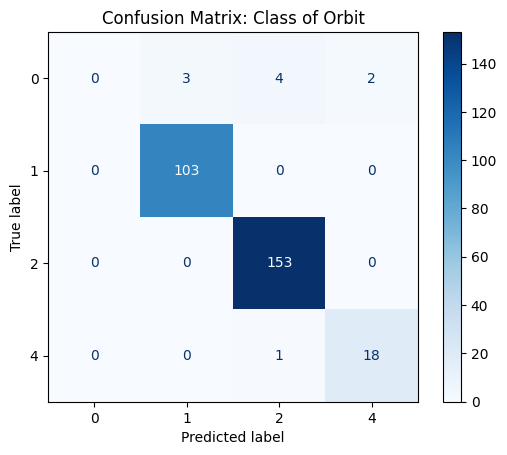

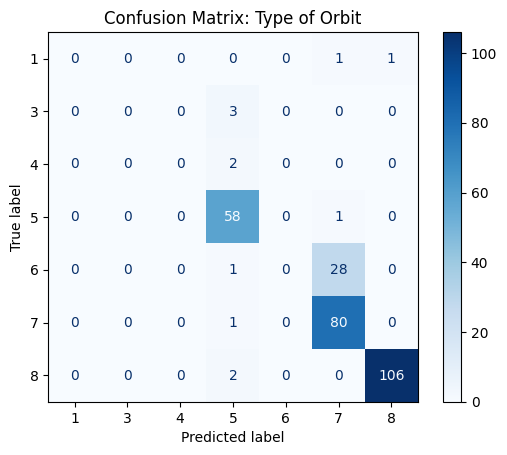

In [155]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_class, y_pred_type = model(X_test_tensor)
    y_pred_class = y_pred_class.argmax(dim=1).numpy()
    y_pred_type = y_pred_type.argmax(dim=1).numpy()

# Confusion Matrices
y_true_class = y_test_class_tensor.numpy()
y_true_type = y_test_type_tensor.numpy()

conf_matrix_class = confusion_matrix(y_true_class, y_pred_class)
conf_matrix_type = confusion_matrix(y_true_type, y_pred_type)

disp_class = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_class, display_labels=np.unique(y_true_class))
disp_class.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Class of Orbit")
plt.show()

disp_type = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_type, display_labels=np.unique(y_true_type))
disp_type.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Type of Orbit")
plt.show()

In [156]:
# Combined accuracy
combined_correct = (y_pred_class == y_test_class_tensor.numpy()) & (y_pred_type == y_test_type_tensor.numpy())
combined_accuracy = combined_correct.mean() * 100
print(f"Combined Accuracy: {combined_accuracy:.2f}%")

Combined Accuracy: 84.86%


Numerical label values converted into the answer key, assume the two LEO values are merged for the above matrix.

In [157]:
# @title Confusion Matrix Key
# Initialize LabelEncoder and fit it to the "Class of Orbit" column
class_encoder = LabelEncoder()
class_encoder.fit(processed_data["Class of Orbit"])

# Generate the mapping of labels to numbers
class_label_mapping = {label: idx for idx, label in enumerate(class_encoder.classes_)}
print("\nClass of Orbit Key:")
for label, idx in class_label_mapping.items():
    print(f"{idx}: {label}")

# Initialize LabelEncoder and fit on the "Type of Orbit" column
type_encoder = LabelEncoder()
type_encoder.fit(processed_data["Type of Orbit"])

# Generate the mapping of labels to numbers
type_label_mapping = {label: idx for idx, label in enumerate(type_encoder.classes_)}
print("Type of Orbit Key:")
for label, idx in type_label_mapping.items():
    print(f"{idx}: {label}")


Class of Orbit Key:
0: Elliptical
1: GEO
2: LEO
3: LEO 
4: MEO
5: Unknown
Type of Orbit Key:
0: Cislunar
1: Deep Highly Eccentric
2: Elliptical
3: Equatorial
4: Molniya
5: Non-Polar Inclined
6: Polar
7: Sun-Synchronous
8: Unknown


The Decision Tree has an accuracy in excess of 90% for any given seed whilst the neural network has accuracy of ≈85%, suggesting that for this particular propblem a neural network is not the optimal way to classify this data. Although that could be due to the dataset only having ≈1400 datapoints without augmentation. The NN seemed to have the greatest issue identifying between polar and sun-synchronous orbits.